# RED PESADA

In [1]:
import networkx as nx 
import numpy as np
import matplotlib.pyplot as plt
import random as r
import scipy.sparse as scp
from matplotlib.ticker import PercentFormatter

In [3]:
def randomn(N, kav):
    p = kav/(N -1)
    net = nx.fast_gnp_random_graph(N, p, directed = False) 
    #net = nx.barabasi_albert_graph(N, kav) 
    adj = nx.adjacency_matrix(net) # adj is a Sparse Matrix of CSR (compressed sparse row) format. 
                               # this means that row slicing is fast
    return net, adj

def weighted_net(N,adj,a,b):
    adj2 = adj.copy()
    adj2 = scp.csr_matrix.astype(adj2, float)   #Cambia la matriz de adjacencia a tipo float
    for i in range(0,N):
        links = adj2[i,i+1:].indices
        for j in range(0, len(links)):
            peso = r.uniform(0.01, 1)
            #peso = np.random.beta(a,b)
            adj2[i, links[j] + i + 1] = peso
            adj2[links[j] + i + 1,i] = peso
    return adj2

def probren1(prob, n, peso):
    return prob*(peso*(n**2 - 1)/n + 1/n)

def probren2(prob, peso):
    return prob + peso*(1- prob)

def remove_deadz(net,est1,N):
    # Eliminamos los nodos con estado = 2 (removed)
    net2 = net.copy()
    for i in range(0,N):
        if est1[i] == 2:
            net2.remove_node(i)
    return net2

def remove_deadzh(net,est1,N):
    # Eliminamos los nodos con estado = 2 (removed)
    net2 = net.copy()
    for i in range(0,N):
        if est1[i] == 2 or est1[i] == 3:
            net2.remove_node(i)
    return net2

def adjacency_survivors(adj2, est1, N):
    # Hacemos una nueva matriz de adyacencia en la que eliminar los links de los nodos removed
    adj3 = adj2.copy()
    adj3 = adj3.todense()
    for i in range(0,N):
        if est1[i] == 2 or est1[i] == 3: #si el nodo está removed, hay que eliminar sus links
            links = np.where(adj3[i,:] !=0. )[1]
            for l in links:
                adj3[i,l] = 0.
                adj3[l,i] = 0.
    return adj3

def weights_survivor(adj3, N):
    # recuperamos los pesos de cada nodo
    pesos = []
    for i in range(0,N):
        for j in range(i+1,N):
            if adj3[i,j] != 0.:
                pesos.append(adj3[i,j])
    return pesos

## Modelos de epidemia 

In [4]:
def SIR_model(N, adj2, beta, alpha, it):
    # "est" es un vector que guarda el estado de cada nodo de la red
    #  est = 0 humano; est = 1 zombie; est = 2 zombie muerto

    est = np.zeros(N, dtype = int)
    est1 = np.zeros(N, dtype = int)

    # paciente zero: el primer infectado por el virus
    pac0 = r.randint(0, N-1)
    est[pac0] = 1
    est1[pac0] = 1

    nH = np.zeros(it, dtype = int)
    nZ = np.zeros(it, dtype = int)
    nR = np.zeros(it, dtype = int)
    suma = np.zeros(it, dtype = int)

    for t in range(0, it): # time

        ##### RECUENTO #####
        nH[t] = len(np.where(est1 == 0)[0])
        nZ[t] = len(np.where(est1 == 1)[0])
        nR[t] = len(np.where(est1 == 2)[0])

        ##### INFECTION #####
        # Identificamos los zombies en la red y las infecciones que producen

        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj2[z,:].indices # nodos que están conectados con z
            relh = rel[est[rel]==0] # nodos humanos conectados con z

            for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado
                betaren = probren1(beta, 1, adj2[z,relh[j]])
                if r.uniform(0, 1) < betaren: # the node is infected
                    est1[relh[j]] = 1 # human turns into zombie


        ##### ZOMBIE REMOVAL #####
        # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.

        zombies_removal = np.where(est == 1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
        for i in range(0, len(zombies_removal)):
            if r.uniform(0, 1) < alpha:
                est1[zombies_removal[i]] = 2 

        est = est1
        suma[t] = nH[t] + nZ[t] + nR[t]
        
    return nH, nZ, nR, suma, est1

def SIR_vitals_model(N, adj2, beta, alpha, delta, it):

    # "est" es un vector que guarda el estado de cada nodo de la red
    #  est = 0 humano; est = 1 zombie; est = 2 zombie muerto; est = 3 humano muerto
    est = np.zeros(N, dtype = int)
    est1 = np.zeros(N, dtype = int)

    # paciente zero: el primer infectado por el virus
    pac0 = r.randint(0, N-1)
    est[pac0] = 1
    est1[pac0] = 1

    nH = np.zeros(it, dtype = int)
    nZ = np.zeros(it, dtype = int)
    nRZ = np.zeros(it, dtype = int)
    nRH = np.zeros(it, dtype = int)
    suma = np.zeros(it, dtype = int)

    for t in range(0, it): # time

        ##### RECUENTO #####
        nH[t] = len(np.where(est1 == 0)[0])
        nZ[t] = len(np.where(est1 == 1)[0])
        nRZ[t] = len(np.where(est1 == 2)[0])
        nRH[t] = len(np.where(est1 == 3)[0])

        ##### INFECTION #####
        # Identificamos los zombies en la red y las infecciones que producen

        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj2[z,:].indices # nodos que están conectados con z
            relh = rel[est[rel]==0] # nodos humanos conectados con z

            for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado
                betaren = probren1(beta, 3, adj2[z,relh[j]])
                if r.uniform(0, 1) < betaren: # the node is infected
                    est1[relh[j]] = 1 # human turns into zombie


        ##### ZOMBIE REMOVAL #####
        # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.
        zombies_removal = np.where(est==1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
        for i in range(0, len(zombies_removal)):
            if r.uniform(0, 1) < alpha:
                est1[zombies_removal[i]] = 2 

        ##### HUMAN REMOVAL #####
        human_removal = np.where(est1==0)[0] # buscamos los humanos que quedan 
        for i in range(0, len(human_removal)):
            if r.uniform(0, 1) < delta:
                est1[human_removal[i]] = 3 

        est = est1
        suma[t] = nH[t] + nZ[t] + nRZ[t] + nRH[t]
    
    return nH, nZ, nRZ, nRH, suma, est1

def SIR_vitals_mil_model(N, adj2, beta, alpha, delta, nu, eta, factor, gamma, it):
    
    nB = 100 # factor de renormalización de la beta en función del peso del link
    
    # mu = probabilidad de convertirse en militar al sobrevivir a un encuentro con un zombie
    # eta = probabilidad de que un militar transforme en militar a un humano
    # factor = factor de reducción de la probabilidad de contagiarse de un militar
    # gamma = probabilidad de que un militar mate un zombie


    # "est" es un vector que guarda el estado de cada nodo de la red
    #  est = 0 humano; 
    # est = 1 zombie; 
    # est = 2 zombie muerto; 
    # est = 3 humano muerto; 
    # est = 4 militar

    est = np.zeros(N, dtype = int)
    est1 = np.zeros(N, dtype = int)

    # paciente zero: el primer infectado por el virus
    pac0 = r.randint(0, N-1)
    est[pac0] = 1
    est1[pac0] = 1

    nH = np.zeros(it, dtype = int)
    nZ = np.zeros(it, dtype = int)
    nRZ = np.zeros(it, dtype = int)
    nRH = np.zeros(it, dtype = int)
    nM = np.zeros(it, dtype = int)

    suma = np.zeros(it, dtype = int)

    for t in range(0, it): # time

        ##### RECUENTO #####
        nH[t] = len(np.where(est1 == 0)[0])
        nZ[t] = len(np.where(est1 == 1)[0])
        nRZ[t] = len(np.where(est1 == 2)[0])
        nRH[t] = len(np.where(est1 == 3)[0])
        nM[t] = len(np.where(est1 == 4)[0])

        ##### INFECTION PARA MILITARES #####

        # Identificamos los zombies en la red y las infecciones que producen
        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj2[z,:].indices # nodos que están conectados con z
            relm = rel[est[rel] == 4] # nodos militares conectados con z

            for j in range(0, len(relm)): # para cada nodo militar conectado con un zombie, comprobamos si está infectado
                betaren = probren1(beta, nB/5, adj2[z,relm[j]])
                if r.uniform(0, 1) < betaren*factor: # the node is infected
                    est1[relm[j]] = 1 # militar turns into zombie
                if r.uniform(0,1) < gamma:
                    est1[z] = 2


        ##### INFECTION PARA HUMANOS #####

        # Identificamos los zombies en la red y las infecciones que producen
        zombies = np.where(est == 1)[0]

        for i in range(0, len(zombies)): # tenemos que buscar los contactos con humanos de cada zombie

            z = zombies[i] # nodo z es un zombie
            rel = adj2[z,:].indices # nodos que están conectados con z
            relh = rel[est[rel]==0] # nodos humanos conectados con z

            for j in range(0, len(relh)): # para cada nodo humano conectado con un zombie, comprobamos si está infectado
                betaren = probren1(beta, nB/5, adj2[z,relh[j]])
                if r.uniform(0, 1) < betaren: # the node is infected
                    est1[relh[j]] = 1 # human turns into zombie
                else: # si el humano sobrevive al encuentro con el zombie, se convierte en militar
                    if r.uniform(0,1) < nu:
                        est1[relh[j]] = 4


        ##### ZOMBIE REMOVAL #####
        # En cada paso temporal, eliminamos a ciertos zombies que no han sido infectados en esta misma iteración.
        zombies_removal = np.where(est==1)[0] # buscamos los zombies que NO han aparecido en esta misma iteración
        for i in range(0, len(zombies_removal)):
            if r.uniform(0, 1) < alpha:
                est1[zombies_removal[i]] = 2 

        ##### HUMAN/MILLITAR REMOVAL #####
        human_mil_removal = np.sort(np.concatenate((np.where(est1 == 0)[0],
                                                    np.where(est1 == 4)[0]), axis = None)) # buscamos los humanos y militares que quedan 
        for i in range(0, len(human_mil_removal)):
            if r.uniform(0, 1) < delta:
                est1[human_mil_removal[i]] = 3 

        #### HUMAN - MILLITAR ENCOUNTER ####
        # Identificamos los militares en la red y los humanos con los que están conectados
        mills = np.where(est == 4)[0]

        for i in range(0, len(mills)): # tenemos que buscar los contactos con humanos de cada zombie

            m = mills[i] # nodo z es un zombie
            rel = adj2[m,:].indices # nodos que están conectados con m
            relh = rel[est[rel]==0] # nodos humanos conectados con m

            for j in range(0, len(relh)): # para cada nodo humano conectado con un militar
                etaren = probren1(prob, nB, adj2[m,relh[j]] )
                if r.uniform(0, 1) < etaren: # the node is transformed
                    est1[relh[j]] = 4 # human turns into millitary


        est = est1
        suma[t] = nH[t] + nZ[t] + nRZ[t] + nRH[t] + nM[t]
    
    return nH, nZ, nRH, nRZ, nM, suma, est1



# RED

In [6]:
N = 5000
kav = 10
a = 1
b = 3
net, adj = randomn(N,kav)
adj2 = weighted_net(N,adj,a,b)

# MODELO SIR

In [25]:
it = 350
beta = 0.01
alpha = 0.03
nH, nZ, nR, suma, est1 = SIR_model(N, adj2, beta, alpha, it)

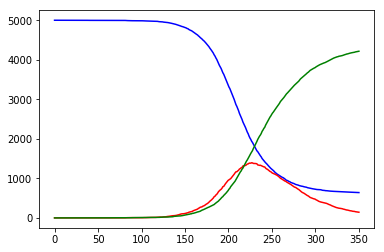

In [26]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nR, color = 'green')

In [19]:
net2 = remove_deadz(net,est1,N)

In [20]:
# asignamos colores a los nodos que tienen estado = 0 (humanos), estado = 1 (zombies)
color_list = []
for i in range(0,N):
    if est1[i] == 0:
        color_list.append('blue')
    elif est1[i] == 1:
        color_list.append('red')

In [21]:
pos = nx.spring_layout(net2)
#pos = nx.fruchterman_reingold_layout(net2, seed = RandomState)

In [22]:
plt.figure(figsize=(20,10))
nx.draw_networkx(net2, with_labels = False, pos = pos, 
                 node_color = color_list, node_size = 20, edge_color = 'darkgray')
plt.show()

In [13]:
adj3 = adjacency_survivors(adj2, est1, N)
pesos = weights_survivor(adj3,N)

In [14]:
plt.figure(figsize=(20,10))
nx.draw_networkx(net2, with_labels = False, pos = pos, node_color = color_list, 
        node_size = 20, edge_color = pesos, edge_cmap = plt.cm.get_cmap('inferno'), edge_vmin=0, edge_vmax=1)
plt.show()

In [16]:
plt.hist(pesos, bins = 95)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-0.27596887, -0.26544255, -0.25491624, -0.24438992, -0.2338636 ,
        -0.22333729, -0.21281097, -0.20228466, -0.19175834, -0.18123203,
        -0.17070571, -0.16017939, -0.14965308, -0.13912676, -0.12860045,
        -0.11807413, -0.10754781, -0.0970215 , -0.08649518, -0.07596887,
        -0.06544255, -0.05491624, -0.04438992, -0.0338636 , -0.02333729,
        -0.01281097, -0.00228466,  0.00824166,  0.01876797,  0.02929429,
         0.03982061,  0.05034692,  0.06087324,  0.07139955,  0.08192587,
         0.09245219,  0.1029785 ,  0.11350482,  0.12403113,

# MODELO SIR + vitals

In [ ]:
N = 5000
kav = 10
#net, adj = randomn(N,kav)
#adj2 = weighted_net(N,adj)

it = 150
beta = 0.009
alpha = 0.05
delta = 0.002
nH, nZ, nRZ, nRH, suma, est1 = SIR_vitals_model(N, adj2, beta, alpha, delta, it)

In [ ]:
plt.plot( np.linspace(0,it,it), nH, color = 'blue')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nRZ, color = 'green')
plt.plot( np.linspace(0,it,it), nRH, color = 'orange')
plt.plot( np.linspace(0,it,it), suma, '--', color = 'black', linewidth = 0.8)

In [ ]:
net2 = remove_deadzh(net,est1,N)
# asignamos colores a los nodos que tienen estado = 0 (humanos), estado = 1 (zombies)
color_list = []
for i in range(0,N):
    if est1[i] == 0:
        color_list.append('blue')
    elif est1[i] == 1:
        color_list.append('red')
pos = nx.spring_layout(net2)
adj3 = adjacency_survivors(adj2, est1, N)
pesos = weights_survivor(adj3,N)
plt.figure(figsize=(20,10))
nx.draw_networkx(net2, with_labels = False, pos = pos, node_color = color_list, 
        node_size = 20, edge_color = pesos, edge_cmap = plt.cm.get_cmap('inferno'), edge_vmin=0, edge_vmax=1)
plt.show()

In [ ]:
plt.hist(pesos, bins = 20)

# MODELO SIR + vitals + militares

In [52]:
beta = 0.02 # infection probability in a zombie-human encounter
alpha = 0.05 # zombie removal probability
delta = 0.001 # human removal probability

# mu = probabilidad de convertirse en militar al sobrevivir a un encuentro con un zombie
# eta = probabilidad de que un militar transforme en militar a un humano
# factor = factor de reducción de la probabilidad de contagiarse de un militar
# gamma = probabilidad de que un militar mate un zombie

nu = 0.02 # probabilidad de convertirse en militar al sobrevivir a un encuentro con un zombie
eta = 0.02 # probabilidad de que un militar transforme en militar a un humano
factor = 0.7 
gamma = 0.08 # probabilidad de que un militar mate un zombie

it = 60
nH, nZ, nRH, nRZ, nM, suma, est1 = SIR_vitals_mil_model(N, adj2, beta, alpha, delta, nu, eta, factor, gamma, it)

In [53]:
plt.plot( np.linspace(0,it,it), nH + nM, color = 'blue')
plt.plot( np.linspace(0,it,it), nZ, color = 'red')
plt.plot( np.linspace(0,it,it), nRZ, color = 'green')
plt.plot( np.linspace(0,it,it), nRH, color = 'orange')
plt.plot( np.linspace(0,it,it), nM, '--', color = 'grey')
plt.plot( np.linspace(0,it,it), suma, '--', color = 'black', linewidth = 0.8)

In [54]:
net2 = remove_deadzh(net, est1, N)
pos = nx.spring_layout(net2, k = 0.1)

In [55]:
# asignamos colores a los nodos que tienen estado = 0 (humanos), estado = 1 (zombies)
color_list = []
for i in range(0,N):
    if est1[i] == 0:
        color_list.append('blue')
    elif est1[i] == 1:
        color_list.append('red')
    elif est1[i] == 4:
        color_list.append('orange')

In [56]:
adj3 = adjacency_survivors(adj2, est1, N)
pesos = weights_survivor(adj3,N)

In [57]:
len(pesos)

612

In [58]:
net2.number_of_edges()

612

In [48]:
plt.figure(figsize=(20,10))
nx.draw_networkx(net2, with_labels = False, pos = pos, node_color = color_list, 
        node_size = 20, edge_color = pesos, edge_cmap = plt.cm.get_cmap('inferno'), edge_vmin=0, edge_vmax=1)
plt.show()

In [50]:
plt.figure(figsize=(20,20))
nx.draw_networkx(net2, with_labels = False, pos = pos, node_color = color_list, 
        node_size = 80, edge_color = pesos, edge_cmap = plt.cm.get_cmap('inferno'), 
                 edge_vmin=0, edge_vmax=1, width = 5)
plt.axis([-0.75,0.75,-0.75,0.75])
plt.show()

(array([17., 17., 29., 18., 14., 19., 19., 20., 17., 25., 24., 28., 18.,
        13., 21., 22., 31., 20., 20., 15., 17., 14., 22., 21., 23., 24.,
        22., 16., 26., 20.]),
 array([0.0109107 , 0.04385839, 0.07680608, 0.10975377, 0.14270146,
        0.17564915, 0.20859684, 0.24154453, 0.27449222, 0.30743991,
        0.3403876 , 0.37333529, 0.40628298, 0.43923067, 0.47217836,
        0.50512605, 0.53807374, 0.57102143, 0.60396912, 0.63691681,
        0.6698645 , 0.70281219, 0.73575988, 0.76870757, 0.80165526,
        0.83460295, 0.86755064, 0.90049833, 0.93344602, 0.96639371,
        0.9993414 ]),
 <a list of 30 Patch objects>)

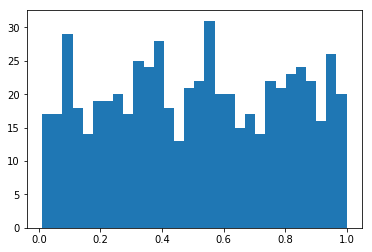

In [61]:
plt.hist(pesos, bins = 30)

In [18]:
len(pesos)

2829